torch.Size([1, 1000])
top_prob, top_class tensor(0.2284) tensor(507) 507
Labels:  ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'American robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'American dipper', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'fire salamander', 'smooth newt', 'newt', 'spotted salamander', 'axolotl', 'American bullfrog', 'tree frog', 'tailed frog', 'loggerhead sea turtle', 'leatherback sea turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'green iguana', 'Carolina anole', 'desert grassland whiptail lizard', 'agama', 'frilled-necked lizard', 'alligator lizard', 'Gila monster', 'European green lizard', 'chameleon', 'Komodo dragon', 'Nile crocodile', 'American alligator', 'triceratops', 'worm snake', 'ring-necked snake', 'eastern hog-nosed snake', 'smooth green snake', 'kingsnake', 'garter snak

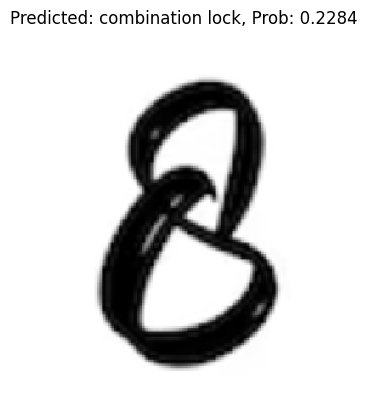

In [3]:
import torch
from torchvision.models import vgg16, VGG16_Weights
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import requests

# Load the model
model = vgg16(weights=VGG16_Weights.DEFAULT)
model.eval()

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_path = "eight.png"
image = Image.open(image_path).convert("RGB")
input_tensor = preprocess(image).unsqueeze(0)

# Inference
with torch.no_grad():
    output = model(input_tensor)
    print(output.shape)
# Convert logits to probabilities and get top prediction
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top_prob, top_class = torch.max(probabilities, 0)
print("top_prob, top_class", top_prob, top_class, top_class.item())

# Get human-readable labels
LABELS_URL = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
labels = requests.get(LABELS_URL).json()
print("Labels: ", labels)
predicted_label = labels[top_class.item()]

# Display results
plt.imshow(image)
plt.title(f"Predicted: {predicted_label}, Prob: {top_prob:.4f}")
plt.axis("off")
plt.show()


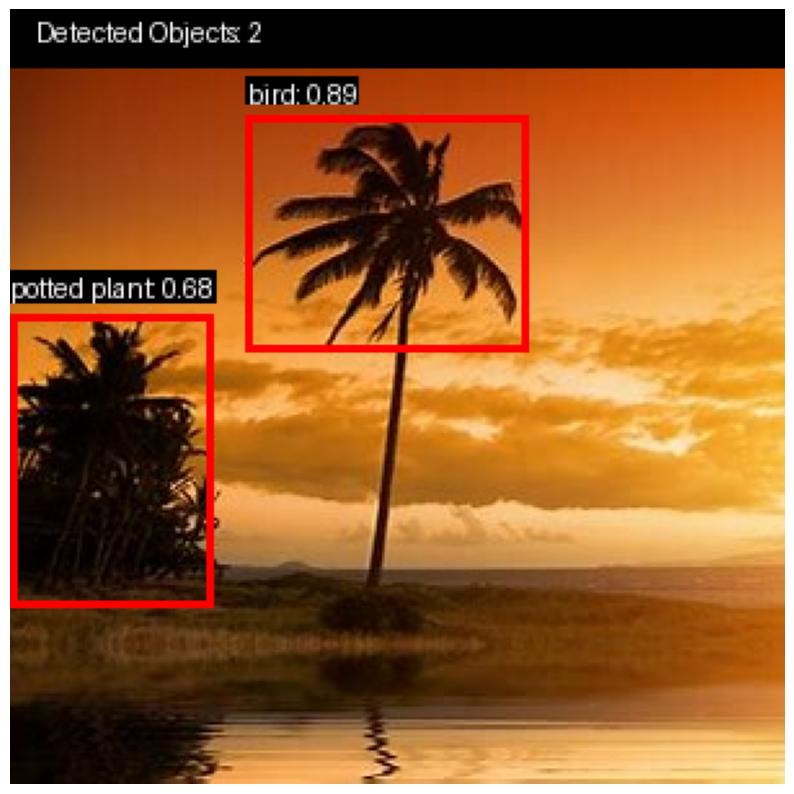

In [5]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Load the pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

# COCO class labels (80 classes + background)
COCO_CLASSES = [
    "__background__", "person", "bicycle", "car", "motorcycle", "airplane", "bus",
    "train", "truck", "boat", "traffic light", "fire hydrant", "N/A", "stop sign",
    "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
    "elephant", "bear", "zebra", "giraffe", "N/A", "backpack", "umbrella", "N/A",
    "N/A", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
    "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
    "bottle", "N/A", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake", "chair", "couch", "potted plant", "bed", "N/A", "dining table", "N/A",
    "N/A", "toilet", "N/A", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone",
    "microwave", "oven", "toaster", "sink", "refrigerator", "N/A", "book", "clock",
    "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]

# Function to load and preprocess an image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image

# Function to draw bounding boxes and title on the image
def draw_boxes_with_title(image, boxes, labels, scores, threshold=0.5):
    draw = ImageDraw.Draw(image)
    detected_objects = 0
    font = ImageFont.load_default()  # Use default font

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            detected_objects += 1
            # Draw bounding box
            draw.rectangle(box.tolist(), outline="red", width=3)

            # Position the label above the box
            text = f"{COCO_CLASSES[label]}: {score:.2f}"
            text_size = draw.textbbox((0, 0), text, font=font)
            text_width, text_height = text_size[2], text_size[3]
            text_position = (box[0], box[1] - text_height - 5)  # 5px padding above the box

            # Add a background rectangle for better visibility
            draw.rectangle(
                [text_position, (text_position[0] + text_width, text_position[1] + text_height)],
                fill="black",
            )
            draw.text(text_position, text, fill="white", font=font)

    # Add a title at the top of the image
    title_text = f"Detected Objects: {detected_objects}"
    title_text_size = draw.textbbox((0, 0), title_text, font=font)
    title_width, title_height = title_text_size[2], title_text_size[3]

    # Draw a black rectangle for the title background
    draw.rectangle([(0, 0), (image.width, title_height + 10)], fill="black")
    draw.text((10, 3), title_text, fill="white", font=font)

    return image

# Function for inference
def predict_with_title(model, image_path, threshold=0.5):
    image = load_image(image_path)
    image_tensor = F.to_tensor(image).unsqueeze(0)  # Convert to tensor and add batch dimension

    with torch.no_grad():
        predictions = model(image_tensor)[0]  # Model output

    boxes = predictions['boxes']
    labels = predictions['labels']
    scores = predictions['scores']

    # Draw boxes and title on the image
    result_image = draw_boxes_with_title(image, boxes, labels, scores, threshold)
    return result_image

# Example usage in Jupyter Notebook
image_path = "tree.jpeg"  # Replace with your image path
result_image = predict_with_title(model, image_path, threshold=0.5)

# Display the image inline in the notebook
plt.figure(figsize=(10, 12))
plt.imshow(result_image)
plt.axis("off")
plt.show()
